<center>
    <h1><b>Pretraining a Transformer Model from Scratch on an Amharic Dataset and Fine-Tuning for Amharic Hate Speech Recognition Task</b></h1>
</center>


## Table of Contents  
1. [Introduction](#introduction)  
2. [Importing Packages](#importing-packages)  
3. [Dataset Collection & Preprocessing](#dataset-collection--preprocessing)  
   - 3.1 [Data Collection](#data-collection)  
   - 3.2 [Data Cleaning](#data-cleaning)  
   - 3.3 [Tokenization](#tokenization)  
   - 3.4 [Tokenizing and Masking](#tokenizing-and-masking)  
   - 3.5 [Creating Training Data Pairs](#creating-training-data-pairs)  
4. [Pretraining the Transformer Model](#pretraining-the-transformer-model)  
   - 4.1 [Positional Encoding](#positional-encoding)  
   - 4.2 [Masking](#masking)  
   - 4.3 [Self Attention](#self-attention)  
   - 4.4 [Encoder](#encoder)  
   - 4.5 [Decoder](#decoder)  
   - 4.6 [Transformer](#transformer)  
   - 4.7 [Initialize_Model](#initialize-model)  
   - 4.8 [Pre-training](#pre-training)  
5. [Fine-Tuning for Hate Speech Recognition](#fine-tuning-for-hate-speech-recognition)  
   - 5.1 [Preparing the Fine-Tuning Dataset](#preparing-the-fine-tuning-dataset)  
   - 5.2 [Adjusting the Model Architecture](#adjusting-the-model-architecture)  
   - 5.3 [Training the Fine-Tuned Model](#training-the-fine-tuned-model)  
6. [Evaluation](#evaluation)  
7. [Deployment on Mahder AI App](#deployment-on-mahder-ai-app)  
8. [Conclusion](#conclusion)

## 1. Introduction  

In this notebook, I will pretrain a Transformer network on an Amharic dataset collected from a variety of Telegram channels, using the Masked Language Model (MLM). The primary objective of pretraining is to enable the model to learn contextualized word and phrase representations, thereby enhancing its understanding of language semantics. The Transformer’s self-attention mechanism plays a crucial role by allowing the model to dynamically weigh different parts of the input sequence, effectively capturing long-range dependencies in the data.  

After pretraining, I will fine-tune the model on a labeled dataset of hate speech and deploy the resulting model in the **Mahder AI** app.


In [1]:
# prompt: import drive

from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [2]:
!pip uninstall -y tensorflow tensorflow-gpu
!apt-get remove --purge '^nvidia-.*'


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'nvidia-driver-550-server' for regex '^nvidia-.*'
Note, selecting 'nvidia-firmware-550-server-550.144.03' for regex '^nvidia-.*'
Note, selecting 'nvidia-firmware-535-535.154.05' for regex '^nvidia-.*'
Note, selecting 'nvidia-docker2' for regex '^nvidia-.*'
Note, selecting 'nvidia-firmware-560-server-560.28.03' for regex '^nvidia-.*'
Note, selecting 'nvidia-driver-570-server' for regex '^nvidia-.*'
Note, selecting 'nvidia-cuda-toolkit-doc' for regex '^nvidia-.*'
Note, selecting 'nvidia-imex' for regex '^nvidia-.*'
Note, selecting 'nvidia-dkms-450-server' for regex '^nvidia-.*'
Note, selecting 'nvidia-firmware-535-server-535.154.05' for regex '^nvidia-.*'
Note, selecting 'nvidia-headless-390' for regex '^nvidia-.*'
Note, selecting 'nvidia-cuda-toolkit-gcc

In [ ]:
!wget -qO- https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-keyring_1.0-1_all.deb | sudo dpkg -i -
!apt update
!apt install -y cuda-11-8 libcudnn8=8.6.0.163-1+cuda11.8


dpkg: error: cannot access archive '-': No such file or directory
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,317 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe 

In [ ]:
!pip install tensorflow==2.13.0


: 

In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.6 MB/s eta 0:00:00



## 2. Importing the Packages

Let's start by importing all the required libraries.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import random
import emoji
import sentencepiece as spm
import string
from collections import Counter
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy


## 3. Dataset Collection & Preprocessing

In [2]:
# prompt: check the availability of gpu for tf

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.__version__

Num GPUs Available:  1


'2.13.0'

### 3.1 Data Collection  

In order to pretrain the Transformer network from scratch, we will use **self-supervised learning**, which requires a large corpus of unlabeled text. We will apply a **Masked Language Model (MLM)** to pre-train the model.  

#### **Why Telegram Channels?**  
Telegram is the most widely used platform for information storage in Ethiopia. For this reason, I have chosen **Telegram channels** as the primary data source. Most of the selected channels are news channels, ensuring a diverse and rich dataset.  

#### **Data Collection Method**  
To collect the data, I used the **Telethon Python library** and the **Telegram API** to scrape text from selected channels.  

#### **Selected Telegram Channels**  
The dataset has been collected from the following Telegram channels:  

- [Tikvah Ethiopia](https://t.me/tikvahethiopia)  
- [Addis Standard Amharic](https://t.me/AddisstandardAmh)  
- [Tarikn Wedehuala](https://t.me/TariknWedehuala)  
- [Addis News](https://t.me/Addis_News)  
- [Zena 24 Now](https://t.me/zena24now)  
- [Tikvah University](https://t.me/TikvahUniversity)  
- [Tikvah Ethiopia Magazine](https://t.me/tikvahethmagazine)  
- [Tikvah Ethiopia Sport](https://t.me/tikvahethsport)  
- [Philosophy Thoughts](https://t.me/Philosophy_Thoughts1)  
- [Mudenyaz](https://t.me/Mudenyaz)  
- [Yemeri Terekoch](https://t.me/yemeri_terekoch)  
- [Bemnet Library](https://t.me/Bemnet_Library)  
- [Amazing Fact](https://t.me/amazing_fact_433)  
- [Zephilosophy](https://t.me/Zephilosophy)  
- [Huluezih](https://t.me/huluezih)  

#### **Accessing Collected Data**  
To access the code and all the raw data collected from each channel, visit the following GitHub repository:  
[GitHub Repository Link](https://github.com/your-repo-link-here).


### 3.2 Data Loading and Cleaning

Next, we will define a function that will load data from a JSON file as an array of strings.

In [3]:
def load_data(filepath):
    return_data=[]
    with open (filepath, "r", encoding="utf-8", errors="replace") as file:
        datas=json.load(file)
        for data in datas:
            return_data.append(data["text"])

    return return_data

The following code shows how the news look like

In [4]:
sample=load_data("datas/sample.json")
for news in sample[:5]:
    print(news)

    print("---------------------------------------------------------------------------------\n\n")

#መቄዶንያ

ሰውን ለመርዳት ሰው መሆን በቂ ነው !

ትላንት የካቲት 1/2017 ዓ/ም በጀመረው የመቄዶንያ የአረጋዊያን እና የአእምሮ ህሙማን መርጃ ማዕከል የድጋፍ ማሰባሰብ ዘመቻ እስኩን 120,000,000 ብር ተሰብስቧል።

መቄዶንያ በሚያስገነባው ሆስፒታል ጭምር ያለው ህንፃ ለማጠናቀቅ የገንዘብ እጥረት አጋጥሞታል። ህንፃው ለማጠናቀቅ ገንዘብ ተቸግረናል። ለማጠናቀቅ ወደ 5 ቢሊዮን ብር ያስፈልጋል።

በቀጥታ ይከታተሉ 👇
https://www.youtube.com/live/q0bMjwt9PvM?feature=shared

የምትችሉትን ሁሉ ድጋፍ አድርጉ።

@tikvahethiopia
---------------------------------------------------------------------------------


🔊 #የሠራተኞችድምጽ

" ቋሚ ሠራተኞች ሆነን ሳለ በደሞዝ ማሻሻያው አልተካተትንም " - የሀዋሳ ዙሪያ ወረዳ መንግስት ሠራተኞች

የማክሮ ኢኮኖሚ ማሻሻያ ሪፎርሙን ተከትሎ የሚከሰቱ የኑሮ ዉድነትና ተያያዥ ጉዳዮችን ታሳቢ በማድረግ የመንግስት ሠራተኞች ደሞዝ ማሻሻያ ተደርጎ ከጥቅምት ወር 2017 ዓ/ም ጀምሮ ተግባራዊ የተደረገ መሆኑ ይታወቃል።

በሲዳማ ክልል፤ ሰሜናዊ ሲዳማ ዞን፤ ሀዋሳ ዙሪያ ወረዳ በተለያዩ የመንግስት መስሪያ ቤቶች የሚሰሩ የመንግስት ሠራተኞች ግን " ከ2012 ዓ/ም ጀምሮ በቋሚነት ተቀጥረን እየሰራን ያለን ቢሆንም በአዲሱ የመንግስት ሠራተኞች የደመወዝ ማሻሻያ አልተካተትንም " ሲሉ ቅሬታቸዉን ለቲክቫህ ኢትዮጵያ አስገብተዋል።

ቅሬታቸዉን ካደረሱን መካከል ፦
- በከተማ ልማትና ኮንስትራክሽን፣
- ማዘጋጃ ቤቶች፣
- በትምህርት ዘርፍ ፣
- በሴቶችና ሕፃናት እንዲሁም በሕብረት ስራ ጽ/ቤቶች የሚሰሩ ሠራተኞች ናቸው።

" በወቅቱ በአግባቡ ማስታወቂያ ወ

Since we are working with a Telegram dataset, we aim to clean the text by removing substrings that are commonly used on the platform, such as hashtagged entities, usernames, hyperlinks,emojis, and english words. To achieve this, we will use Python's re library to perform regular expression operations. We will define specific search patterns and use the sub() method to remove matches by replacing them with an empty string (''). We will also remove unecessary multiple spaces to a single space




In [5]:
def clean_text(text):
    text = re.sub(r'https?://[^\s\n\r]+', '', text)
    text = re.sub(r'#\S+', '', text)
    text=re.sub(r'@\S+', '', text)
    text=emoji.replace_emoji(text," ")
    english_pattern = re.compile(r'\b[A-Za-z]+\b')
    cleaned_text = re.sub(english_pattern, '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text





Let's test the above function on sample data


let's load our training data and see how many contents we have and what the first 5 contents look like

In [6]:
data=load_data("datas/totaldata.json")
number_of_contents=len(data)
print(f'Total number of contents: {number_of_contents}\n')
print(f'First 5 contents: \n')
for news in data[:5]:
    print(news)
    print("---------------------------------------------------------------------------------\n\n")




Total number of contents: 193419

First 5 contents: 

#መቄዶንያ

ሰውን ለመርዳት ሰው መሆን በቂ ነው !

ትላንት የካቲት 1/2017 ዓ/ም በጀመረው የመቄዶንያ የአረጋዊያን እና የአእምሮ ህሙማን መርጃ ማዕከል የድጋፍ ማሰባሰብ ዘመቻ እስኩን 120,000,000 ብር ተሰብስቧል።

መቄዶንያ በሚያስገነባው ሆስፒታል ጭምር ያለው ህንፃ ለማጠናቀቅ የገንዘብ እጥረት አጋጥሞታል። ህንፃው ለማጠናቀቅ ገንዘብ ተቸግረናል። ለማጠናቀቅ ወደ 5 ቢሊዮን ብር ያስፈልጋል።

በቀጥታ ይከታተሉ 👇
https://www.youtube.com/live/q0bMjwt9PvM?feature=shared

የምትችሉትን ሁሉ ድጋፍ አድርጉ።

@tikvahethiopia
---------------------------------------------------------------------------------


🔊 #የሠራተኞችድምጽ

" ቋሚ ሠራተኞች ሆነን ሳለ በደሞዝ ማሻሻያው አልተካተትንም " - የሀዋሳ ዙሪያ ወረዳ መንግስት ሠራተኞች

የማክሮ ኢኮኖሚ ማሻሻያ ሪፎርሙን ተከትሎ የሚከሰቱ የኑሮ ዉድነትና ተያያዥ ጉዳዮችን ታሳቢ በማድረግ የመንግስት ሠራተኞች ደሞዝ ማሻሻያ ተደርጎ ከጥቅምት ወር 2017 ዓ/ም ጀምሮ ተግባራዊ የተደረገ መሆኑ ይታወቃል።

በሲዳማ ክልል፤ ሰሜናዊ ሲዳማ ዞን፤ ሀዋሳ ዙሪያ ወረዳ በተለያዩ የመንግስት መስሪያ ቤቶች የሚሰሩ የመንግስት ሠራተኞች ግን " ከ2012 ዓ/ም ጀምሮ በቋሚነት ተቀጥረን እየሰራን ያለን ቢሆንም በአዲሱ የመንግስት ሠራተኞች የደመወዝ ማሻሻያ አልተካተትንም " ሲሉ ቅሬታቸዉን ለቲክቫህ ኢትዮጵያ አስገብተዋል።

ቅሬታቸዉን ካደረሱን መካከል ፦
- በከተማ ልማትና ኮንስትራክሽን፣
- ማዘጋጃ ቤቶች፣
- በትምህርት ዘርፍ ፣
- በሴቶችና ሕፃናት እንዲሁም

Let's clean our data using clean_text function and sample our data to see the difference between the original and cleaned data

In [7]:
cleaned_data=[clean_text(content) for content in data]

Let's see the total number of words and total number of unique words in our training data.

In [8]:
total=0
for news in cleaned_data:
    news_array=news.split()
    total+=len(news_array)
print(f'Total number of words in the dataset: {total}\n')
alldata=" ".join(cleaned_data)
counter=Counter(alldata.split())
print(f'Total number of unique words in the dataset: {len(counter)}\n')


Total number of words in the dataset: 15290227

Total number of unique words in the dataset: 832978



In [9]:
index=37430
print(f"Data at index {index} before cleaning: \n\n",data[index])
print("\n---------------------------------------------------------------------------------\n\n")
print(f"Data at index {index} after cleaning: \n\n",cleaned_data[index])

Data at index 37430 before cleaning: 

 update⬆️የቴፒ ከተማ የዛሬ ጥዋት ድባብ እና አጠቃላይ የከተማዋ ሁኔታ ከከተማው ነዋሪ አምደበት።
@tseabwolde @tikvahethiopia

---------------------------------------------------------------------------------


Data at index 37430 after cleaning: 

 የቴፒ ከተማ የዛሬ ጥዋት ድባብ እና አጠቃላይ የከተማዋ ሁኔታ ከከተማው ነዋሪ አምደበት።


### 3.3 Tokenization

#### Next, We Will Train the Tokenizer

Tokenization is a critical step in natural language processing (NLP) as it converts raw text into smaller, meaningful units (tokens) that can be processed by machine learning models. Effective tokenization ensures that the model can understand and interpret the text accurately, which is essential for tasks like text classification, machine translation, and sentiment analysis.

For this task, we will use the **SentencePiece tokenizer** instead of traditional word-based tokenization. The [SentencePieceTokenizer](https://www.tensorflow.org/text/api_docs/python/text/SentencepieceTokenizer) is a powerful tool that tokenizes text into **subword units**, which offers several advantages:

1. **Handling Complex Word Structures**: SentencePiece breaks words into smaller subword units, making it effective for handling complex word structures and morphological variations, which are common in languages like Amharic.
2. **Out-of-Vocabulary (OOV) Words**: By using subword tokenization, SentencePiece can handle out-of-vocabulary words more gracefully, as it can decompose them into known subword units.
3. **Multilingual Support**: SentencePiece is language-agnostic, making it suitable for multilingual datasets. This is particularly useful for Amharic, as it can handle the repetition of common subwords and morphological patterns unique to the language.
4. **Simplified Preprocessing**: SentencePiece works directly on raw text, eliminating the need for extensive preprocessing steps like word segmentation or stemming.
5. **Seamless Integration**: It integrates seamlessly with popular machine learning frameworks like TensorFlow and PyTorch, ensuring consistent tokenization across training and inference pipelines.

Given these benefits, SentencePiece is an ideal choice for tokenizing Amharic text, as it can effectively capture the language's unique characteristics while simplifying the overall preprocessing workflow.

Let's train sentencepiece tokenizer model first. in order to do that we need to save our cleaned data into a single corpus of text in .txt file

In [ ]:
#with open("datas/cleaned_data.txt", "a") as file:
  #  for content in cleaned_data:
   #     file.write(content + "\n")

In [ ]:
input_file="datas/cleaned_data.txt"
model_prefix="amharic_sp_model"
print("Training SentencePiece model...")

spm.SentencePieceTrainer.train(
    input=input_file,
    model_prefix=model_prefix,
    vocab_size=100000,
    model_type="unigram",
    character_coverage=0.995,
    num_threads=6,
    max_sentence_length=8192,
    split_by_whitespace=True,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,

)
print("Training complete! Check 'amharic_bpe.model' and 'amharic_bpe.vocab'.")

Training SentencePiece model...
Training complete! Check 'amharic_bpe.model' and 'amharic_bpe.vocab'.


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: datas/cleaned_data.txt
  input_format: 
  model_prefix: amharic_sp_model
  model_type: UNIGRAM
  vocab_size: 100000
  self_test_sample_size: 0
  character_coverage: 0.995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 8192
  num_threads: 6
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 1
  bos_id: 2
  eos_id: 3
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_p

After training the sentencepeice tokenizer the next step is to load the trainied tokenizer model

In [10]:
tokenizer=spm.SentencePieceProcessor(model_file="amharic_sp_model.model")

This code shows the process of tokenizing individual words from a given text, in this case, the first entry of the dataset.

In [11]:
# printing the encoding of each word to see how subwords are tokenized
tokenized_text = [(list(tokenizer.tokenize(word)), word) for word in cleaned_data[3000].split()]

print("Word\t\t-->\tTokenization")
print("-"*40)
for element in tokenized_text:
    print(f"{element[1]:<8}\t-->\t{element[0]}")


Word		-->	Tokenization
----------------------------------------
በአማራ    	-->	[503]
ክልል     	-->	[41]
መዲና     	-->	[2571]
በባህር    	-->	[3954]
ዳር      	-->	[577]
ከተማ     	-->	[25]
ቀበሌ     	-->	[556]
14      	-->	[589]
ትላንት    	-->	[414]
መጋቢት    	-->	[915]
29      	-->	[1161]
የመግሪብ   	-->	[40582, 39560]
ሰላት     	-->	[22531]
ሰግደው    	-->	[80378]
ሲመለሱ    	-->	[5520]
የነበሩ    	-->	[296]
አባት     	-->	[1033]
ከ3      	-->	[12, 391]
ልጆቹ     	-->	[8106]
እንዲሁም   	-->	[56]
አንድ     	-->	[60]
ጎረቤታቸውን 	-->	[63799, 5]
ጨምሮ     	-->	[166]
አጠቃላይ   	-->	[462]
5       	-->	[189]
ሰዎች     	-->	[27]
በተከፈተባቸው	-->	[6, 31096]
የጥይት    	-->	[9820]
እሩምታ    	-->	[22829]
መገደላቸው  	-->	[4926]
ተነግሯል።  	-->	[528]
ትላንትና   	-->	[9146]
ምሽት     	-->	[368]
በግፍ     	-->	[7180]
የተገደሉት  	-->	[6444]
፥       	-->	[4, 1]
አቶ      	-->	[44]
ሙሄ      	-->	[51148]
፣       	-->	[33]
ልጃቸው    	-->	[4786]
አበባዉ    	-->	[43, 124]
ሙሄ      	-->	[51148]
፣       	-->	[33]
ሽኩር     	-->	[24929]
ሙሄ      	-->	[51148]
፣       	-->	[33]
ሙላት     	-->	[915

Now let's take data from the cleaned_data  and see how the tokenization of the whole content looks like

In [12]:
index=890
print(f"Data at index {index} before tokenization:", cleaned_data[index])
print("\n---------------------------------------------------------------------------------")
print(f"Data at index {index} after tokenization: ", tokenizer.encode(cleaned_data[index]))
print("\n---------------------------------------------------------------------------------")
print(f"Data at index {index} after detokenization:", tokenizer.encode_as_pieces(cleaned_data[index]))

Data at index 890 before tokenization: " ሰላም ከአንገት በላይና ዝም ላለማለት ያህል የምንናገረው ሳይሆን ዋጋ ከፍለን የምናመጣው ነው " - ቅዱስነታቸው ዛሬ የሰላም ሚኒስቴር አንድ ዓለም አቀፍ ኮንፈረንስ አዘጋጅቶ ነበር። በዚህ መድረክ ላይም የሰላም ሚኒስትር አቶ ብናልፍ አዱዓለም ፣ የኢትዮጵያ የሃይማኖት ተቋማት የበላይ ጠባቂ አባቶች፣ ብፁዓን አበው ሊቃነ ጳጳሳት ወኤጲስ ቆጶሳት ፣ የመንግሥት ባለስልጣናት ፣ አባሳደሮች ጭምር ተገኝተው ነበር። በመድረኩ ፤ ብፁዕ ወቅዱስ አቡነ ማትያስ ቀዳማዊ ፓትርያርክ ርእሰ ሊቃነ ጳጳሳት ዘኢትዮጵያ ሊቀ ጳጳስ ዘአክሱም ወእጨጌ ዘመንበረ ተክለሃይማኖት መልዕክት አስተላልፈዋል። ቅዱስነታቸው ምን አሉ ? (ከመልዕክታቸው የተወሰደ) " ሰላም የሰው ልጆች ፍላጎት፣ የብዙ ምንዱባን የየዕለት ናፍቆት ነው። የበርካታ ዘመናት ቅርሶች፤ ጊዜ፣ ገንዘብ እና የሰው ጉልበት የፈሰሰባቸው ግንባታዎች በሰላም ማጣት በቅጽበት ይፈርሳሉ። ሰላም ካለ የዓለም ሀብት ለሁሉም በቂ ነው። ሰላም ማጣት ግን ብዙ ሠራዊት፣ ብዙ የጦር መሳሪያ እንዲዘጋጅ እያደረገ ሀብትን ያወድማል። ጦርነት ማለት ሀብትና ሕይወትን ወደሚነድ እሳት ውስጥ መጣል ነው። የአንደኛና የሁለተኛ ዓለም ጦርነት፣ ታሪክ ብቻ ሳይሆን ጠባሳው አሁንም የዓለምን መልክ አበላሽቶታል። ሰላም በውስጥዋ ገራምነት፣ ትዕግሥት፣ ታዛዥነትና በትህትና ዝቅ ማለት ስለሚገኙ መራራ ትመስላለች፤ በውጤቷ ግን ሀገርን ከጥፋት፣ ሕዝብን ከመከራ ማትረፍ የሚቻል በመሆኑ ዋጋዋ ከፍ ያለ ነው። ቅድስት ቤተ ክርስቲያናችን ፦ ° ሰላም የሆነው ክርስቶስ የሚሰበክባት፣ ° የሰላም መልእክተኞች በውስጥዋ የሚመላለሱባት፣ ° በግብረ ኃጢአት የወደቁት በንስሓ ከእግዚአብሔር ጋር የሚታረቁባት የሰላም ድልድይ ስ

To pretrain our Transformer network, we will use the Masked Language Model (MLM) approach. This technique involves randomly masking a percentage of words in a sentence and replacing them with special tokens. The model then attempts to predict these masked words, enabling it to learn contextual and semantic representations effectively.

I will be implementing the Masked language model (MLM) as shown in the following image.

<img src = "images/losses.png" width="600" height = "400">

Assume you have the following text: <span style = "color:blue"> **ሰላም <span style = "color:red">የሰው ልጆች </span> ፍላጎት፣ የብዙ ምንዱባን የየዕለት <span style = "color:red">ናፍቆት</span>  ነው።** </span>     


Now as input you will mask the words in red in the text:

<span style = "color:blue"> **Input:**</span> ሰላም  **X** ፍላጎት፣ የብዙ ምንዱባን የየዕለት **Y** ነው።

<span style = "color:blue">**Output:**</span> The model should predict the words(s) for **X** and **Y**.

**[EOS]** will be used to mark the end of the target sequence.

As you can see above, I were able to take a piece of string and tokenize it.

Now I will create `input` and `target` pairs that will allow me to pre-train the model. The model uses the ids at the end of the vocab file as sentinels. For example, it will replace:
   - `vocab_size - 1` by `<Z>`
   - `vocab_size - 2` by `<Y>`
   - and so forth.
   
It assigns every word a `chr`.

The `pretty_decode` function below, which I will use in a bit, helps in handling the type when decoding.

Notice that:
```python
string.ascii_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
```



In [13]:
def get_sentinels(tokenizer, display=False):
    sentinels = {}
    vocab_size = tokenizer.vocab_size()
    for i, char in enumerate(reversed(string.ascii_letters), 1):
        decoded_text = tokenizer.detokenize([vocab_size - i])

        # Sentinels, ex: <Z> - <a>
        sentinels[decoded_text] = f'<{char}>'

        if display:
            print(f'The sentinel is <{char}> and the decoded token is:', decoded_text)

    return sentinels


def pretty_decode(encoded_str_list, sentinels, tokenizer):
    # If already a string, just do the replacements.
    if isinstance(encoded_str_list, str):
        for token, char in sentinels.items():
            encoded_str_list = re.sub(re.escape(token), char, encoded_str_list)
        return encoded_str_list

    # We need to decode and then prettyfy it.
    return pretty_decode(tokenizer.detokenize(encoded_str_list), sentinels, tokenizer)

In [14]:
sentinels = get_sentinels(tokenizer, display=True)

The sentinel is <Z> and the decoded token is: ጂዮፖሊታን
The sentinel is <Y> and the decoded token is: ኮሌጃችን
The sentinel is <X> and the decoded token is: ብሮንዝ
The sentinel is <W> and the decoded token is: ኮንቲኔ
The sentinel is <V> and the decoded token is: አፈግፍገ
The sentinel is <U> and the decoded token is: አይምሮአችን
The sentinel is <T> and the decoded token is: የተወጠረ
The sentinel is <S> and the decoded token is: ያካብቱ
The sentinel is <R> and the decoded token is: ይበረታል
The sentinel is <Q> and the decoded token is: ጂአንግ
The sentinel is <P> and the decoded token is: ያስችሉታል
The sentinel is <O> and the decoded token is: ,744
The sentinel is <N> and the decoded token is: ወጤታማ
The sentinel is <M> and the decoded token is: እሰጣችኋለሁ
The sentinel is <L> and the decoded token is: ያሳምነኝ
The sentinel is <K> and the decoded token is: በትምርት
The sentinel is <J> and the decoded token is: ያስፈልጋችኋል
The sentinel is <I> and the decoded token is: አልሆነልኝም
The sentinel is <H> and the decoded token is: ትጠልቅ
The sent

Now, let's use the `pretty_decode` function in the following sentence.

<a name='1-5'></a>
### 3.4 - Tokenizing and Masking

In this task, I will implement the `tokenize_and_mask` function, which tokenizes and masks input words based on a given probability. The probability is controlled by the `noise` parameter, typically set to mask around `15%` of the words in the input text. The function will generate two lists of tokenized sequences following the algorithm outlined below:


###  tokenize_and_mask

- Start with two empty lists: `inps` and `targs`
- Tokenize the input text using the given tokenizer.
- For each `token` in the tokenized sequence:
  - Generate a random number(simulating a weighted coin toss)
  - If the random value is greater than the given threshold(noise):
    - Add the current token to the `inps` list
  - Else:
    - If a new sentinel must be included:
      - Compute the next sentinel ID using a progression.
      - Add a sentinel into the `inps` and `targs` to mark the position of the masked element.
    - Add the current token to the `targs` list.

** There's a special case to consider. If two or more consecutive tokens get masked during the process, no need to add a new sentinel to the sequences. To account for this, use the `prev_no_mask` flag, which starts as `True` but is turned to `False` each time I mask a new element. The code that adds sentinels will only be executed if, before masking the token, the flag was in the `True` state.


In [15]:
def tokenize_and_mask(text,
                      noise=0.15,
                      randomizer=np.random.uniform,
                      tokenizer=None):
    """Tokenizes and masks a given input.

    Args:
        text (str or bytes): Text input.
        noise (float, optional): Probability of masking a token. Defaults to 0.15.
        randomizer (function, optional): Function that generates random values. Defaults to np.random.uniform.
        tokenizer (function, optional): Tokenizer function. Defaults to tokenize.

    Returns:
        inps, targs: Lists of integers associated to inputs and targets.
    """

    # Current sentinel number (starts at 0)
    cur_sentinel_num = 0

    # Inputs and targets
    inps, targs = [], []

    # Vocab_size
    vocab_size = int(tokenizer.vocab_size())

    # EOS token id
    # Must be at the end of each target!
    eos = tokenizer.piece_to_id("</s>")



    # prev_no_mask is True if the previous token was NOT masked, False otherwise
    # set prev_no_mask to True
    prev_no_mask = True

    # Loop over the tokenized text
    for token in tokenizer.tokenize(text):

        # Generate a random value between 0 and 1
        rnd_val = randomizer()

        # Check if the noise is greater than a random value (weighted coin flip)
        if noise > rnd_val:

            # Check if previous token was NOT masked
            if prev_no_mask:

                # Current sentinel increases by 1
                cur_sentinel_num += 1

                # Compute end_id by subtracting current sentinel value out of the total vocabulary size
                end_id = vocab_size - cur_sentinel_num

                # Append end_id at the end of the targets
                targs.append(end_id)

                # Append end_id at the end of the inputs
                inps.append(end_id)

            # Append token at the end of the targets
            targs.append(token)

            # set prev_no_mask accordingly
            prev_no_mask = False

        else:

            # Append token at the end of the inputs
            inps.append(token)

            # Set prev_no_mask accordingly
            prev_no_mask = True


    # Add EOS token to the end of the targets
    targs.append(eos)



    return inps, targs

I will now take random value from the cleaned_data and pass it to `tokenize_and_mask` function and see how it randomly masks and separate inputs and targets

In [16]:
random_data=cleaned_data[32000]
print("Random data before Masking : \n\n", random_data)

Random data before Masking : 

 የፀጥታ ሁኔታው አስተማማኝ ነው~ጅግጅጋ! . . ስምንተኛውን የከተሞች ፎረም ለማካሄድ ዝግጅቱ መጠናቀቁንና ምንም አይነት የፀጥታ ችግር አለመኖሩን የከተማ ልማትና ኮንስትራክሽን ሚኒስቴር ሚኒስትር ዴኤታ አቶ ካሳሁን ጎፌ ተናገሩ። ዝግጅቱን አስመልክቶ በጅግጅጋ መግለጫ የሰጡት ሚኒስትር ዴኤታው ጅጅጋ ላይ የፀጥታ ሁኔታው አስተማማኝ ነው"፤ የክልሉ ፖሊስ ከፌዴራል የፀጥታ አካላት ጋርም በቅንጅት እየሰራ ነው ብለዋል። በከተማዋ አስተማማኝ የፀጥታ ሁኔታ መኖሩን የገለፁት ሚኒስትር ዴኤታው ተሳታፊ ከተሞች ወደጅግጅጋ ገብተው ዝግጅታቸውን ጀምረዋል ብለዋል። ዝግጅቶችን በተመለከተ ከነገ ጀምሮ እስከ ረቡዕ ከሚኖሩ ዝግጅቶች መካከል በጅግጅጋ ስቴዲየም የመክፈቻ ስነስርዐት፣ በከተሞች የስራ ዕድል ፈጠራ ኢንተርፕራይዞች ልማት፣ በመሬት ልማት ማኔጅመንት፣ በዘርፉ አጀንዳዎች ማለትም በከተማ ልማት፣ አረንጓዴ ልማትና አካባቢ ጥበቃ፣ በቤቶችና ኮንስትራክሽን እንዲሁም ተያያዥ ዘርፎች ዙሪያ ጥናታዊ ፅሁፎች ይቀርባሉ። አቶ ካሳሁን ከተሞች ራሳቸውን የሚያስተዋውቁበት ኤግዚቢሽን የሚካሄድ ሲሆን ከዚህ በፊት በተደረጉ ፎረሞች የተስተዋለው የድምፅ ብክለት በዚህ አመት እንዳይኖር ከከተሞች ጋር መግባባት ላይ ተደርሷል ብለዋል። ሀሙስ በሚኖረው የማጠቃለያ ስርዓት ለሞዴል ኢንተርፕራይዞች፣ ለሴት ስራ ፈጣሪዎች፣ በሁሉም ክልሎች ካሉ የሴክተር ተቋማት በአፈፃፀም ብልጫ ላገኙ እንዲሁም ለዩኒቨርሲቲ ተመራቂ ስራ ፈጣሪዎች እውቅናና ሽልማት ይሰጣል ተብሏል። በተመሳሳይ የዘጠነኛው የኢትዮጵያ ከተሞች ፎረም አዘጋጅ በእለቱ ይፋ ይደረጋል፤ የዋንጫ ርክክብም ይኖራል ብለዋል ሚኒስትር ዴኤታው። ስምንተኛውን የከተሞች ፎረም የተለየ ለማድረግ ከማሌዥያ አለምአቀፍ የከተ

In [17]:
inps_sample,targs_sample=tokenize_and_mask(random_data,noise=0.15,randomizer=np.random.uniform,tokenizer=tokenizer)



In [18]:
print('Inputs: \n\n', pretty_decode(inps_sample, sentinels, tokenizer))
print('\nTargets: \n\n', pretty_decode(targs_sample, sentinels, tokenizer))

Inputs: 

 የፀጥታ ሁኔታው አስተማማኝ ነው ⁇ ጅግጅጋ! . . ስምንተኛውን የከተሞች ፎረም ለማካሄድ ዝግጅቱ መጠናቀቁንና ምንም አይነት የፀጥታ<Z> አለመኖሩን የከተማ ልማትና ኮንስትራክሽን ሚኒስቴር ሚኒስትር ዴኤታ አቶ ካሳሁን ጎፌ ተናገሩ። ዝግጅቱን አስመልክቶ በጅግጅጋ መግለጫ የሰጡት ሚኒስትር ዴኤታው ጅጅጋ ላይ የፀጥታ ሁኔታው አስተማማኝ ነው"፤ የክልሉ ፖሊስ ከፌዴራል የፀጥታ አካላት ጋርም በቅንጅት<Y> በከተማዋ አስተማማኝ የፀጥታ ሁኔታ መኖሩን የገለፁት ሚኒስትር ዴኤታው ተሳታፊ ከተሞች ወደጅግጅጋ<X> ዝግጅታቸውን ጀምረዋል ብለዋል። ዝግጅቶችን በተመለከተ ከነገ ጀምሮ እስከ ረቡዕ ከሚኖሩ ዝግጅቶች መካከል <W> ስቴዲየም የመክፈቻ <V>ት፣ በከተሞች<U> ዕድል <T> ኢንተርፕራይዞች ልማት፣ በመሬት ልማት ማኔጅመንት፣ በዘርፉ አጀንዳዎች ማለትም<S> ልማት፣ አረንጓዴ ልማትና አካባቢ ጥበቃ፣ በቤቶች <R> ኮንስትራክሽን እንዲሁም ተያያዥ ዘርፎች ዙሪያ ጥናታዊ ፅሁፎች ይቀርባሉ። አቶ ካሳሁን ከተሞች ራሳቸውን የሚያስተዋውቁበት ኤግዚቢሽን የሚካሄድ ሲሆን ከዚህ በፊት በተደረጉ ፎረሞች የተስተዋለው የድምፅ ብክለት በዚህ አመት እንዳይኖር ከከተሞች ጋር መግባባት ላይ<Q> ብለዋል። ሀሙስ በሚኖረው የማጠቃለያ ስርዓት ለሞዴል ኢንተርፕራይዞች፣ ለሴት ስራ ፈጣሪዎች፣ በሁሉም ክልሎች ካሉ የሴክተር ተቋማት በአፈፃፀም ብልጫ <P> እንዲሁም ለዩኒቨርሲቲ ተመራቂ<O> ፈጣሪዎች<N>ና <M> ይሰጣል ተብሏል።<L> የኢትዮጵያ ከተሞች ፎረም አዘጋጅ በእለቱ ይፋ ይደረጋል፤ የዋንጫ ርክክብ <K> ይኖራል ብለዋል ሚኒስትር ዴኤታው። ስምንተኛው <J> የከተሞች ፎረም የተለየ ለማድረግ <I>ማሌዥያ አለምአቀፍ<H> ፎረም ልምድ ተወስ ⁇ ል ያሉት አቶ ካሳሁን ፎረሙ ለመጀመሪያ ጊዜ በታዳጊ

In [19]:
tokenizer.detokenize(tokenizer.tokenize("አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለማገዝ ብሞክር  እርስዎ የመፅሀፍ ቅዱሱ የዳዊት  ኦሮዮንን መንገድ በመምረጥዎ በይፋ ለመፃፍ ተገድጃለሁ  አሁንም መረጃው እንዴት እሱ ጋር ደረሰ የሚለውን ውትወታ ትተው በማንኛውም መንገድ ቀጥተኛ ምላሽ ይስጡኝ   ከመስከረም   ወዲያ አሁን ያለሁ መንግስት ህጋዊ የስራ ዘመኑ ስለሚያበቃ የባለአደራ መንግስት እንዲቋቋም ሆኖም አሁን ያለው የአብይ መንግስት አስፈፃሚ አካል የመንግስትን የእለ ተእለት ተግባራትን እየከወነ ምርጫ እስኪደረግ ለ አመት እእነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደረግ በመግለጫው ጠይቀዋል የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የእውቀት ጎዳና አይኑ ያላየው ጆሮው ያልሰማው ልቡ ያላሰበው እውቀትና ብልሀት የለምከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመልክ በመልኩ ሲቀዳበት የኖረ ከኢትዮጵያ አልፎ ለአለም ሲታደል የኖረውና የሚኖረው እውቀት የተገኘበት ታላቅ ነገድ ነው ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ ህዝብ ላይ ብቻ ነውሌላው የትህነግን ባንዲራ ለብሶየኦነግን ባንዲራ እያውለበለበ የኢትዮጵያን ሰንደቅአላማ በእግሩ ረግጦታልጨርቅ ነው ብለው አቃጥለውታልቀዳደው ጥለውታል"))

'አስቀድሜ ጥያቄዬ በጨዋነት በውስጥ መስመር እንዲደርስዎ አድርጌ ፍትህን ለማገዝ ብሞክር እርስዎ የመፅሀፍ ቅዱሱ የዳዊት ኦሮዮንን መንገድ በመምረጥዎ በይፋ ለመፃፍ ተገድጃለሁ አሁንም መረጃው እንዴት እሱ ጋር ደረሰ የሚለውን ውትወታ ትተው በማንኛውም መንገድ ቀጥተኛ ምላሽ ይስጡኝ ከመስከረም ወዲያ አሁን ያለሁ መንግስት ህጋዊ የስራ ዘመኑ ስለሚያበቃ የባለአደራ መንግስት እንዲቋቋም ሆኖም አሁን ያለው የአብይ መንግስት አስፈፃሚ አካል የመንግስትን የእለ ተእለት ተግባራትን እየከወነ ምርጫ እስኪደረግ ለ አመት እእነዚህን ወሳኝ ጉዳዮችን የሚያስፈፅም አካል እንዲቋቋምና ክትትል እንዲደረግ በመግለጫው ጠይቀዋል የአማራ ህዝብ በአእምሮ ክንፉ ያልበረረበት ጥበብና ፍልስፍና ያልከፈተው የእውቀት ጎዳና አይኑ ያላየው ጆሮው ያልሰማው ልቡ ያላሰበው እውቀትና ብልሀት የለምከአማራ ህዝብ የሀገሪቱ ዘርፈ ብዙ እውቀት መንጭቶ የሞላበትከሙላቱም በመልክ በመልኩ ሲቀዳበት የኖረ ከኢትዮጵያ አልፎ ለአለም ሲታደል የኖረውና የሚኖረው እውቀት የተገኘበት ታላቅ ነገድ ነው ዛሬ በየትኛውም መለኪያ ይሁን መመዘኛ ኢትዮጵያዊነት የሚንፀባረቀው በአማራ ህዝብ ላይ ብቻ ነውሌላው የትህነግን ባንዲራ ለብሶየኦነግን ባንዲራ እያውለበለበ የኢትዮጵያን ሰንደቅአላማ በእግሩ ረግጦታልጨርቅ ነው ብለው አቃጥለውታልቀዳደው ጥለውታል'

### 3.5 Creating the training data pairs

Now I will create pairs using the cleaned_data by iterating over the data and create(inp,targ) pairs using the function I defined above

After completing data preprocessing and defining the dataset, I encountered an issue while training the model: the maximum sequence length is around 1300 tokens, causing the model to run out of memory and crash. This happens because transformer models, when trained using a masked language model (MLM) objective, have quadratic complexity (O(n²)) concerning sequence length, leading to excessive memory usage for long sequences. To resolve this issue, we need to reduce the size of the input sequences by spliting a single news into multiple small news(max_size words per news). this process will reduce the size of each news but will increase the number of training datas as we split single data into multiple datas

In [20]:

max_size=50

def reduce_size(data, max_size):
    for element in data:  # Loop over each sub-array in the main array
        sub_array = element.split()
        for i in range(0, len(sub_array), max_size):  # Split each sub-array into chunks
            yield  ' '.join(sub_array[i:i + max_size])

cleaned_data_reduced=list(reduce_size(cleaned_data,max_size))
print(f'Number of contents before reduced: {len(cleaned_data)}')
print(f'Number of contents after reduced: {len(cleaned_data_reduced)}')
print(f"maximum size before reduced: {max([len(content.split()) for content in cleaned_data])}")
print(f"maximum size after reduced: {max([len(content.split()) for content in cleaned_data_reduced])}")



Number of contents before reduced: 193419
Number of contents after reduced: 408671
maximum size before reduced: 836
maximum size after reduced: 50


let us see sample the news before and after reducing

In [21]:
print("Data before reduced: \n\n", cleaned_data[0])
print("\n---------------------------------------------------------------------------------\n\n")
print("Data after reduced: \n\n", cleaned_data_reduced[0])
print("\n---------------------------------------------------------------------------------\n\n")
print("Data after reduced: \n\n", cleaned_data_reduced[1])

Data before reduced: 

 ሰውን ለመርዳት ሰው መሆን በቂ ነው ! ትላንት የካቲት 1/2017 ዓ/ም በጀመረው የመቄዶንያ የአረጋዊያን እና የአእምሮ ህሙማን መርጃ ማዕከል የድጋፍ ማሰባሰብ ዘመቻ እስኩን 120,000,000 ብር ተሰብስቧል። መቄዶንያ በሚያስገነባው ሆስፒታል ጭምር ያለው ህንፃ ለማጠናቀቅ የገንዘብ እጥረት አጋጥሞታል። ህንፃው ለማጠናቀቅ ገንዘብ ተቸግረናል። ለማጠናቀቅ ወደ 5 ቢሊዮን ብር ያስፈልጋል። በቀጥታ ይከታተሉ የምትችሉትን ሁሉ ድጋፍ አድርጉ።

---------------------------------------------------------------------------------


Data after reduced: 

 ሰውን ለመርዳት ሰው መሆን በቂ ነው ! ትላንት የካቲት 1/2017 ዓ/ም በጀመረው የመቄዶንያ የአረጋዊያን እና የአእምሮ ህሙማን መርጃ ማዕከል የድጋፍ ማሰባሰብ ዘመቻ እስኩን 120,000,000 ብር ተሰብስቧል። መቄዶንያ በሚያስገነባው ሆስፒታል ጭምር ያለው ህንፃ ለማጠናቀቅ የገንዘብ እጥረት አጋጥሞታል። ህንፃው ለማጠናቀቅ ገንዘብ ተቸግረናል። ለማጠናቀቅ ወደ 5 ቢሊዮን ብር ያስፈልጋል። በቀጥታ ይከታተሉ የምትችሉትን ሁሉ

---------------------------------------------------------------------------------


Data after reduced: 

 ድጋፍ አድርጉ።


In [22]:
inputs_targets_pairs=[tokenize_and_mask(text.encode('utf-8', errors="ignore").decode('utf-8'),tokenizer=tokenizer) for text in cleaned_data_reduced]


In [23]:
for pairs in inputs_targets_pairs[:2]:
    print('Inputs: \n\n', pretty_decode(pairs[0], sentinels, tokenizer))
    print('\nTargets: \n\n', pretty_decode(pairs[1], sentinels, tokenizer))
    print("\n---------------------------------------------------------------------------------\n\n")

Inputs: 

 ሰውን ለመርዳት ሰው መሆን በቂ ነው !<Z> የካቲት 1/2017 ዓ/ም በጀመረው የመቄዶንያ የአረጋዊያን እና የአእምሮ ህሙማን መርጃ ማዕከል የድጋፍ<Y>ኩን 120,000,000 ብር ተሰብስቧል። መቄዶንያ በሚያስገነባው ሆስፒታል ጭምር ያለው ህንፃ<X> እጥረት አጋጥሞታል። ህንፃው ለማጠናቀቅ ገንዘብ ተቸግረናል። ለማጠናቀቅ ወደ 5 ቢሊዮን ብር ያስፈልጋል። በቀጥታ ይከታተሉ የምትችሉትን ሁሉ

Targets: 

 <Z> ትላንት<Y> ማሰባሰብ ዘመቻ እስ<X> ለማጠናቀቅ የገንዘብ

---------------------------------------------------------------------------------


Inputs: 

 ድጋፍ አድርጉ።

Targets: 

 

---------------------------------------------------------------------------------




Let's split the data into training and validation datasets.

In [24]:
print("Total number of inputs and targets pairs: ",len(inputs_targets_pairs))
training_size=int(len(inputs_targets_pairs)*0.8)
training_data=inputs_targets_pairs[:training_size]
validation_data=inputs_targets_pairs[training_size:]
print(f"Training data size: {len(training_data)}")
print(f"Validation data size: {len(validation_data)}")

Total number of inputs and targets pairs:  408671
Training data size: 326936
Validation data size: 81735


For training a Tensorflow model we need to arrange the data into datasets. Now, I will get the `inputs` and the `targets` for the transformer model from the `training_data and validation_data`. Before creating the dataset, I need to be sure that all `inputs` have the same length by truncating the longer sequences and padding the shorter ones with `0`. The same must be done for the targets. The function `tf.keras.preprocessing.sequence.pad_sequences` will help us here.

In [25]:
training_data_inputs_padded=tf.keras.utils.pad_sequences(
    [pairs[0] for pairs in training_data],
    maxlen=None,
    dtype='int32',
    padding='post',
    truncating='post',
)
training_data_targets_padded=tf.keras.utils.pad_sequences(
    [pairs[1] for pairs in training_data],
    maxlen=None,
    dtype='int32',
    padding='post',
    truncating='post',
)

validation_data_inputs_padded=tf.keras.utils.pad_sequences(
    [pairs[0] for pairs in validation_data],
    maxlen=None,
    dtype='int32',
    padding='post',
    truncating='post',
)

validation_data_targets_padded=tf.keras.utils.pad_sequences(
    [pairs[1] for pairs in validation_data],
    maxlen=None,
    dtype='int32',
    padding='post',
    truncating='post',
)
BUFFER_SIZE = 12000
BATCH_SIZE = 32
training_dataset_final=tf.data.Dataset.from_tensor_slices((training_data_inputs_padded,training_data_targets_padded))
validation_dataset_final=tf.data.Dataset.from_tensor_slices((validation_data_inputs_padded,validation_data_targets_padded))
training_dataset_final=training_dataset_final.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset_final=validation_dataset_final.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



2025-02-23 22:27:54.876577: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-23 22:27:54.876623: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-23 22:27:54.876630: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-23 22:27:54.876686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-23 22:27:54.876730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [26]:
print(f'maximum size of training data inputs: {training_data_inputs_padded.shape[1]}')
print(f'maximum size of training data targets: {training_data_targets_padded.shape[1]}')
print(f'maximum size of validation data inputs: {validation_data_inputs_padded.shape[1]}')
print(f'maximum size of validation data targets: {validation_data_targets_padded.shape[1]}')
print("seems good size for small memory devices")

maximum size of training data inputs: 206
maximum size of training data targets: 65
maximum size of validation data inputs: 135
maximum size of validation data targets: 49
seems good size for small memory devices


Let's Tokenize both the training and validation sets using our tokenizer

## 4. Pretraining the Transformer Model

Now I am going to define the structure of the transformer network and pretrain it on the dataset given above. The general structure of the transformer model we will build is shown in the figure below

<center> <img src = "images/fulltransformer.png" width="500" height="600"></center>

## Positional Encoding

As you can see in the figure, the input embeddings are added with positional embedding vectors to capture the position of words in a sentence. The following function creates positional encoding given the embedding vectors.

In sequence-to-sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model. However, when you train a Transformer network using multi-head attention, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network using these sine and cosine formulas:

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$

$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$

Where:

*   `d` is the dimension of the word embedding and positional encoding.
*   `pos` is the position of the word.
*   `i` refers to each of the different dimensions in the positional encodings, where `i = k // 2`.

To develop some intuition about positional encodings, you can think of them broadly as a feature that contains the information about the relative positions of words. The sum of the positional encoding and word embedding is ultimately what is fed into the model.  If you just hard code the positions in, say by adding a matrix of 1's or whole numbers to the word embedding, the semantic meaning is distorted. Conversely, the values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted, and is instead enriched with positional information. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data.

### Sine and Cosine Angles

Notice that even though the sine and cosine positional encoding equations take in different arguments (`2i` versus `2i+1`, or even versus odd numbers) the inner terms for both equations are the same:

$$\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}}$$

Consider the inner term as you calculate the positional encoding for a word in a sequence:

$PE_{(pos, 0)}= sin\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right)$, since solving `2i = 0` gives `i = 0`

$PE_{(pos, 1)}= cos\left(\frac{pos}{{10000}^{\frac{0}{d}}}\right)$, since solving `2i + 1 = 1` gives `i = 0`

The angle is the same for both! The angles for $PE_{(pos, 2)}$ and $PE_{(pos, 3)}$ are the same as well, since for both, `i = 1` and therefore the inner term is $\left(\frac{pos}{{10000}^{\frac{2}{d}}}\right)$. This relationship holds true for all paired sine and cosine curves:

| k             | 0                         | 1                         | 2                         | 3                         | ... | d - 2                     | d - 1                     |
| ------------- | ------------------------- | ------------------------- | ------------------------- | ------------------------- | --- | ------------------------- | ------------------------- |
| encoding(0) = | [sin(θ(0, 0, d))         | cos(θ(0, 0, d))         | sin(θ(0, 1, d))         | cos(θ(0, 1, d))         | ... | sin(θ(0, d//2, d))        | cos(θ(0, d//2, d))        |
| encoding(1) = | [sin(θ(1, 0, d))         | cos(θ(1, 0, d))         | sin(θ(1, 1, d))         | cos(θ(1, 1, d))         | ... | sin(θ(1, d//2, d))        | cos(θ(1, d//2, d))        |
| ...           | ...                       | ...                       | ...                       | ...                       | ... | ...                       | ...                       |
| encoding(pos) =| [sin(θ(pos, 0, d))        | cos(θ(pos, 0, d))        | sin(θ(pos, 1, d))        | cos(θ(pos, 1, d))        | ... | sin(θ(pos, d//2, d))       | cos(θ(pos, d//2, d))]      |


In [27]:
def positional_encoding(positions, d_model):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        positions (int): Maximum number of positions to be encoded
        d_model (int): Encoding size

    Returns:
        pos_encoding (tf.Tensor): A matrix of shape (1, position, d_model) with the positional encodings
    """

    position = np.arange(positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2

    # initialize a matrix angle_rads of all the angles
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)



## 4.2 Masking

The masking we will define here is different from the masking we used while preparing the data for Masked Language modeling.


There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence.

### 1.1 - Padding Mask

Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"],
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, zeros will also be added for padding.

When pasing these vectors through the attention layers, the zeros will typically disappear  (you will get completely new vectors given the mathematical operations that happen in the attention block). However, you still want the network to attend only to the first few numbers in that vector (given by the sentence length) and this is when a padding mask comes in handy. You will need to define a boolean mask that specifies to which elements you must attend (1) and which elements you must ignore (0) and you do this by looking at all the zeros in the sequence. Then you use the mask to set the values of the vectors (corresponding to the zeros in the initial vector) close to negative infinity (-1e9).

Imagine your input vector is `[87, 600, 0, 0, 0]`. This would give you a mask of `[1, 1, 0, 0, 0]`. When your vector passes through the attention mechanism, you get another (randomly looking) vector, let's say `[1, 2, 3, 4, 5]`, which after masking becomes `[1, 2, -1e9, -1e9, -1e9]`, so that when you take the softmax, the last three elements (where there were zeros in the input) don't affect the score.

The [MultiheadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/) layer implemented in Keras, uses this masking logic.

**Note:** The below functions create the masking of both types.

In [28]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells

    Arguments:
        decoder_token_ids (matrix like): matrix of size (n, m)

    Returns:
        mask (tf.Tensor): binary tensor of size (n, 1, m)
    """
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)

    # add extra dimensions to add the padding to the attention logits.
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :]


def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones

    Arguments:
        sequence_length (int): matrix size

    Returns:
        mask (tf.Tensor): binary tensor of size (sequence_length, sequence_length)
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask


## 4.3 - Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need".

<center><img src="images/attention.png" alt="Encoder" width="600"/></center>

<center><caption><font color='purple'><b>Figure 1: Self-Attention calculation visualization</font></</caption></center>
    

The use of self-attention paired with traditional convolutional networks allows for parallelization which speeds up training. we will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode


This will be handled by Tensorlfow so we will not searately define a function to handel self-attention.


## 4.4 Encoder

Now we will define the encoder part of the transformer using multi-head attention and feed forward.
The structure of the model we will implement will look like the following figure.

<center><img src="images/encoders.png" alt="Encoder" width="400" /> </center>

As you can see in the above figure inside the Encoder there is a feed forward layer. Here we will use 2 Dense layers as part of the Feed Forward Network

In [29]:
def FullyConnected(embedding_dim, fully_connected_dim):
    """
    Returns a sequential model consisting of two dense layers. The first dense layer has
    fully_connected_dim neurons and is activated by relu. The second dense layer has
    embedding_dim and no activation.

    Arguments:
        embedding_dim (int): output dimension
        fully_connected_dim (int): dimension of the hidden layer

    Returns:
        _ (tf.keras.Model): sequential model
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

Next we will define the encoder layer class that contains both the multi-head attention and the FullyConnected layer

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network.
    This architecture includes a residual connection around each of the two
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):

        super(EncoderLayer, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not
                    treated as part of the input
        Returns:
            encoder_layer_out (tf.Tensor): Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(x, x, x, mask)  # Self attention (batch_size, input_seq_len, fully_connected_dim)

        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the
        # output of the multi-head attention layer
        skip_x_attention = self.layernorm1(x + self_mha_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, fully_connected_dim)

        # apply dropout layer to ffn output during training
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output, training=training)

        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output
        # to get the output of the encoder layer
        encoder_layer_out = self.layernorm2(skip_x_attention + ffn_output)  # (batch_size, input_seq_len, embedding_dim)

        return encoder_layer_out


Now let's define the full Encoder Layer including the Embedding of the tokens and addition of positional embedding with Dropout layer before entering the Encoder

In [31]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    encoder Layers

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
        Forward pass for the Encoder

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            mask (tf.Tensor): Boolean mask to ensure that the padding is not
                    treated as part of the input

        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, seq_len, embedding dim)
        """
        seq_len = tf.shape(x)[1]

        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, embedding_dim)

## 4.6 Decoder

Now we will define the decoder part of the transformer using masked multi-head attention, multi-head attention and feed forward.

<b>N.B  pre-training transformer with both Encoder and decoder with MLM is not common task as most models like BERT which are pretrained using masked language modeling(MLM) need only encoders. But here I used both encoder and decoders so that the model can be further pre-trained or fine-tuned for tasks that need both encoder and decoder, like Neural Machine translation as well.</b>

The structure of the decoder layer we will implement will look like the following figure.

<center><img src="images/decoders.png" alt="Encoder" width="400" /> </center>

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks,
    one that takes the new input and uses self-attention, and the other
    one that combines it with the output of the encoder, followed by a
    fully connected block.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.mha2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=dropout_rate
        )

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim,
            fully_connected_dim=fully_connected_dim
        )

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output (tf.Tensor): Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            out3 (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, target_seq_len)
            attn_weights_block2 (tf.Tensor): Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """


        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)

        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training
        mult_attn_out1, attn_weights_block1 = self.mha1(x,x,x,look_ahead_mask, return_attention_scores=True)

        # apply layer normalization (layernorm1) to the sum of the attention output and the input
        Q1 = self.layernorm1(mult_attn_out1 + x)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output.
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1,enc_output,enc_output, padding_mask, return_attention_scores=True)

        # # apply layer normalization (layernorm2) to the sum of the attention output and the Q from the first block
        mult_attn_out2 = self.layernorm2(mult_attn_out2+Q1)

        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)

        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output =self.dropout_ffn(ffn_output)

        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 =self.layernorm3(ffn_output+mult_attn_out2)


        return out3, attn_weights_block1, attn_weights_block2


Now let's define the full Decoder Layer

In [33]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    decoder Layers

    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder

        Arguments:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len)
            enc_output (tf.Tensor):  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            x (tf.Tensor): Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}


        # create word embeddings
        x = self.embedding(x)

        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # add positional encodings to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask=look_ahead_mask,
                                                   padding_mask=padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights[f'decoder_layer{i+1}_block1_self_att'] = block1
            attention_weights[f'decoder_layer{i+1}_block2_decenc_att'] = block2


        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

## 4.6 Transformer

Now we will combine both the encoder and the decoder layers defined above into a single transformer model. The full structure of the model we will form is depicted below. In the code, in addition to encoder and decoder we will add a final Dense layer with softmax  activation.

<center><img src="images/transformer.png" width="3" height="2"/></center>

In [34]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size,
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation='softmax')

    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence (tf.Tensor): Tensor of shape (batch_size, input_seq_len)
                              An array of the indexes of the words in the input sentence
            output_sentence (tf.Tensor): Tensor of shape (batch_size, target_seq_len)
                              An array of the indexes of the words in the output sentence
            training (bool): Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask (tf.Tensor): Boolean mask to ensure that the padding is not
                    treated as part of the input
            look_ahead_mask (tf.Tensor): Boolean mask for the target_input
            dec_padding_mask (tf.Tensor): Boolean mask for the second multihead attention layer
        Returns:
            final_output (tf.Tensor): The final output of the model
            attention_weights (dict[str: tf.Tensor]): Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)

        """


        enc_output = self.encoder(input_sentence, training, enc_padding_mask)
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training,
           look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)


        return final_output, attention_weights

Let's see the total number of Parameters of our model

In [35]:
# 0 is the padding value
sentence_a = np.array([[2, 3, 1, 3, 0, 0, 0]])
sentence_b = np.array([[1, 3, 4, 0, 0, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_a)
dec_padding_mask = create_padding_mask(sentence_a)

look_ahead_mask = create_look_ahead_mask(sentence_a.shape[1])

test_summary, att_weights = transformer(
    sentence_a,
    sentence_b,
    False,
    enc_padding_mask,
    look_ahead_mask,
    dec_padding_mask
)

transformer.summary()

NameError: name 'transformer' is not defined

## 4.7 Intialize Model

Now we will intialize our model to pre-train it on the data we defined. Most of the parameter values we will use here are taken form the <a href="https://arxiv.org/abs/1706.03762">Attention is All You Need</a> paper

In [36]:
#let's find the maximum length in our training data to set it as the maximum positional encoding
POSITIONAL_ENCODING_INPUT_LENGTH =training_data_inputs_padded.shape[1]
POSITIONAL_ENCODING_TARGET_LENGTH =training_data_targets_padded.shape[1]
print(f"Maximum positional encoding length for input: {POSITIONAL_ENCODING_INPUT_LENGTH}")
print(f"Maximum positional encoding length for target: {POSITIONAL_ENCODING_TARGET_LENGTH}")



Maximum positional encoding length for input: 206
Maximum positional encoding length for target: 65


In [36]:
# Define the model parameters
NUM_LAYERS = 6
EMBEDDING_DIM = 512
FULLY_CONNECTED_DIM = 2048
NUM_HEADS= 8
vocab_size = tokenizer.vocab_size()


# Initialize the model
transformer = Transformer(
    NUM_LAYERS,
    EMBEDDING_DIM,
    NUM_HEADS,
    FULLY_CONNECTED_DIM,
    vocab_size,
    vocab_size,
    POSITIONAL_ENCODING_INPUT_LENGTH,
    POSITIONAL_ENCODING_TARGET_LENGTH,
)

## 4.8 Pre-training

In [38]:
import tensorflow as tf

# Check if TensorFlow can access the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1



We have finished defining our model and processing our traning and validation datas. The next step will be training !


In [ ]:

# Define the loss function and optimizer
loss_object = SparseCategoricalCrossentropy(from_logits=False, reduction='none')
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps=4000):
        super().__init__()
        self.embedding_dim = tf.cast(embedding_dim, tf.float32)  # Ensure embedding_dim is float32
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)   # Ensure warmup_steps is float32

    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast step to float32 to avoid int64 issues
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.embedding_dim) * tf.math.minimum(arg1, arg2)  # Fixed typo: minium -> minimum

learning_rate = CustomSchedule(EMBEDDING_DIM)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Define metrics to track loss and accuracy
train_loss = Mean(name='train_loss')
train_accuracy = SparseCategoricalAccuracy(name='train_accuracy')
val_loss = Mean(name='val_loss')
val_accuracy = SparseCategoricalAccuracy(name='val_accuracy')

# Function to calculate the loss
def loss_function(real, pred, mask):
    """
    Arguments:
        real (tf.Tensor): Ground truth labels
        pred (tf.Tensor): Model predictions
        mask (tf.Tensor): Mask to ignore padding tokens
    Returns:
        loss (tf.Tensor): Computed loss
    """
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

# Function to create masks for the input and target sequences
def create_masks(inp, tar):
    """
    Arguments:
        inp (tf.Tensor): Input sequence
        tar (tf.Tensor): Target sequence
    Returns:
        enc_padding_mask (tf.Tensor): Padding mask for encoder
        look_ahead_mask (tf.Tensor): Look-ahead mask for decoder
        dec_padding_mask (tf.Tensor): Padding mask for decoder
    """
    enc_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_padding_mask = create_padding_mask(inp)
    return enc_padding_mask, look_ahead_mask, dec_padding_mask

# Training step function
@tf.function
def train_step(inp, tar):
    """
    Arguments:
        inp (tf.Tensor): Input sequence
        tar (tf.Tensor): Target sequence
    """
    tar_inp = tar[:, :-1]  # Shifted target input for teacher forcing
    tar_real = tar[:, 1:]  # Actual target output

    # Create masks
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        # Forward pass
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, look_ahead_mask, dec_padding_mask)
        # Compute loss
        loss = loss_function(tar_real, predictions, create_padding_mask(tar_real))

    # Compute gradients and update weights
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Update metrics
    train_loss(loss)
    train_accuracy(tar_real, predictions)

# Validation step function
@tf.function
def val_step(inp, tar):
    """
    Arguments:
        inp (tf.Tensor): Input sequence
        tar (tf.Tensor): Target sequence
    """
    tar_inp = tar[:, :-1]  # Shifted target input for teacher forcing
    tar_real = tar[:, 1:]  # Actual target output

    # Create masks
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar_inp)

    # Forward pass
    predictions, _ = transformer(inp, tar_inp, False, enc_padding_mask, look_ahead_mask, dec_padding_mask)
    # Compute loss
    loss = loss_function(tar_real, predictions, create_padding_mask(tar_real))

    # Update metrics
    val_loss(loss)
    val_accuracy(tar_real, predictions)



Let's baby sit the training with 3 epoch each time and save the weights then continue for 3 steps and so until we reach good accuracy and low loss

In [ ]:
#First training
train_losses = []
val_losses = []

EPOCHS = 1
step=1
for epoch in range(EPOCHS):
    # Reset metrics at the start of each epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Training loop
    for (batch, (inp, tar)) in enumerate(training_dataset_final):
        train_step(inp, tar)
        if batch % 2 == 0:
            print(f'Epoch {epoch + 1}, Batch {batch}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}')

    # Validation loop
    for (batch, (inp, tar)) in enumerate(validation_dataset_final):
        val_step(inp, tar)

    # Append loss values to the lists
    train_losses.append(train_loss.result())
    val_losses.append(val_loss.result())

    # Print metrics at the end of each epoch
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss.result()}, Train Accuracy: {train_accuracy.result()}')
    print(f'Epoch {epoch + 1}, Val Loss: {val_loss.result()}, Val Accuracy: {val_accuracy.result()}')
    transformer.save_weights(f"model_weights/model_weights_{epoch}.h5")


KeyboardInterrupt: 

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Save the plot as an image file
plt.savefig(f'loss_images/training_validation_loss{step}.png')

# Optionally, display the plot
plt.show()

In [ ]:
#next steps
train_losses = []
val_losses = []

EPOCHS = 1
step=1
transformer.load_weights(f"model_weights/model_weights_{step-1}.h5")
for epoch in range(EPOCHS):
    # Reset metrics at the start of each epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Training loop
    for (batch, (inp, tar)) in enumerate(training_dataset_final):
        train_step(inp, tar)
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1}, Batch {batch}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result()}')

    # Validation loop
    for (batch, (inp, tar)) in enumerate(validation_dataset_final):
        val_step(inp, tar)

    # Append loss values to the lists
    train_losses.append(train_loss.result())
    val_losses.append(val_loss.result())

    # Print metrics at the end of each epoch
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss.result()}, Train Accuracy: {train_accuracy.result()}')
    print(f'Epoch {epoch + 1}, Val Loss: {val_loss.result()}, Val Accuracy: {val_accuracy.result()}')
    transformer.save_weights(f"model_weights/model_weights_{epoch}.h5")


In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Save the plot as an image file
plt.savefig(f'loss_images/training_validation_loss{step}.png')

# Optionally, display the plot
plt.show()

# 5. Fine-Tuning for Hate Speech Recognition

Fine-tuning is the process of adapting a pre-trained model to a specific task, in this case, hate speech recognition. This involves taking the pre-trained transformer model and training it further on a smaller, task-specific dataset. Fine-tuning allows the model to leverage the general language understanding it gained during pre-training while specializing in the nuances of hate speech detection.  

We have pre-trained the model using **Masked Language Modeling (MLM)**, a self-supervised task that enables the model to capture semantic meanings for Amharic text. The next step is to take the checkpoints of our pre-trained model, remove the final layer, and lock all the remaining layers. We will then add new layers and train only the newly added layers on our labeled hate speech dataset.  

If this approach does not yield satisfactory results, we will unlock some of the pre-trained layers and fine-tune them alongside the new layers. This allows the model to adapt more effectively to the specific task while retaining the knowledge it gained during pre-training.

## 5.1 Preparing the Fine-Tuning Dataset

This time, instead of collecting and labeling a hate speech recognition dataset myself, I will utilize an existing dataset to fine-tune the model. The dataset I will use is available at [https://data.mendeley.com/datasets/ymtmxx385m/1](https://data.mendeley.com/datasets/ymtmxx385m/1). This dataset contains labeled examples of hate speech, making it suitable for fine-tuning the pre-trained model for the specific task of hate speech recognition.  

By leveraging this dataset, I can save time and resources while ensuring the model is trained on high-quality, annotated data. The dataset will be preprocessed to align with the input format required by the model.

This approach allows me to focus on adapting the pre-trained model to the task of hate speech detection without the overhead of data collection and labeling. The fine-tuning process will involve training the model on this dataset, evaluating its performance, and iterating as needed to achieve the desired results.

The original dataset from the source is inside the folder /data/original_hate_speech_data. lets see what the datas look like and process it for our model


In [37]:
with open("datas/original_hate_speech_data/posts.txt", "r") as file:
    post_data = file.readlines()
with open("datas/original_hate_speech_data/labels.txt", "r") as file:
    labels = file.readlines()

print(f"Total number of post datas: {len(post_data)}")
print(f"Total number of label datas: {len(labels)}")



Total number of post datas: 30000
Total number of label datas: 30000


In [38]:
start=1800
end=1810
sample_post_data = post_data[start:end]
sample_label_data = labels[start:end]
for i,(post,label) in enumerate(zip(sample_post_data,sample_label_data)):
    print(f"Post {i+1}: {post}")
    print(f"Label {i+1}: {label}")
    print("\n---------------------------------------------------------------------------------\n\n")

Post 1: አንት እንከፍ መርጠህ አማራ ሆነህ ተወልደሀል

Label 1: Hate


---------------------------------------------------------------------------------


Post 2: ፂላ በዝቷል እሳ ኮሜንት ላይ

Label 2: Hate


---------------------------------------------------------------------------------


Post 3: አብን ዛሬ ባወጣው መግለጫ የአብይ አህመድ መንግስት ያለአግባብ ያሰራቸውን አመራሮቹን እና አባላቶቹን እንዲለቅቅ ጠይቋል

Label 3: Free


---------------------------------------------------------------------------------


Post 4: ከበግ ዝርፍያ ወደ ታሪክ ዘረፋ

Label 4: Free


---------------------------------------------------------------------------------


Post 5: አማራ የኢትዮጲያ ሲል ነው ሚያምርበት

Label 5: Free


---------------------------------------------------------------------------------


Post 6: ኸረ ሼም ነው የቄሳርን ለቄሳር

Label 6: Free


---------------------------------------------------------------------------------


Post 7: ክርስቲስ ሰህለነክርስቶስ መሀረናይቅር በለና

Label 7: Free


---------------------------------------------------------------------------------


Post 8: ወገን እንዴት ናችሁ 

Let's change the labels into binary. 1 mean Free and 0 mean hate

In [39]:
#first lates make sure the labels are only Hate and Free
labels_array=[label.strip() for label in labels]
total_labels=0
for label in labels_array:
    if label.lower() in ["hate","free"]:
        total_labels+=1
if total_labels==len(labels):
    print("All labels either hate or free")
else:
    print("Not all labels are hate or free, the total number of correct labels is: ",total_labels)
    print("Please check the labels")



All labels either hate or free


Now let as change the labels into binary and save. Uncomment the cell only if labels_binary.txt data is not available inside datas/original_hate_speech_data. Or you can  delete the file labels_binary.txt inside datas/original_hate_speech_data, uncomment the code and run it. Otherwise it will duplicate the labels data  2 times

In [40]:

# for label in labels_array:
#     with open("/Users/mahder/Real Projects/Mahder AI/Training_models/Transformer_classifier_app_1/datas/original_hate_speech_data/labels_binary.txt", "a") as file:
#         if label.lower()=="hate":
#             file.write("1\n")
#         else:
#             file.write("0\n")

In [41]:

# let's check if it is correctly changed into binary
with open("datas/original_hate_speech_data/labels_binary.txt", "r") as file:
    binary_labels = file.readlines()
binary_labels_array=[int(label.strip()) for label in binary_labels]
for binary, label in zip(binary_labels_array,labels_array):
    if label.lower()=="hate":
        assert binary==1
    else:
        assert binary==0
print("All labels are correctly changed into binary")

All labels are correctly changed into binary


Let's process the datas into a form suitable for our model and tensorflow

In [42]:
#tokenize the post data
post_data_array=[post.strip() for post in post_data]
tokenized_hate_speech_data=[tokenizer.tokenize(post) for post in post_data_array]

In [43]:
#let's visialize what the tokenization looks like
print("Original post data: \n\n", post_data_array[1742])
print("\n---------------------------------------------------------------------------------\n\n")
print("Tokenized post data: \n\n", tokenized_hate_speech_data[1742])
print("\n---------------------------------------------------------------------------------\n\n")
print("Tokenized data as subwords: \n\n", tokenizer.id_to_piece(tokenized_hate_speech_data[1742]))

Original post data: 

 አማርኛን እና አማራው የሚባለው በድሮ ጊዜ ምን አገናኘው

---------------------------------------------------------------------------------


Tokenized post data: 

 [1649, 5, 7, 745, 22, 3638, 45221, 38, 107, 81333, 22]

---------------------------------------------------------------------------------


Tokenized data as subwords: 

 ['▁አማርኛ', 'ን', '▁እና', '▁አማራ', 'ው', '▁የሚባለው', '▁በድሮ', '▁ጊዜ', '▁ምን', '▁አገናኘ', 'ው']


In [44]:
tokenized_hate_speech_data_padded=tf.keras.utils.pad_sequences(
    tokenized_hate_speech_data,
    maxlen=200,
    dtype='int32',
    padding='post',
    truncating='post',
)

In [45]:
training_hate_final_input=tokenized_hate_speech_data_padded[:28000]
training_hate_final_output=binary_labels_array[:28000]
validation_hate_final_input=tokenized_hate_speech_data_padded[28000:]
validation_hate_final_output=binary_labels_array[28000:]


In [46]:
HATE_BUFFER_SIZE = 3000
HATE_BATCH_SIZE = 32
training_final=tf.data.Dataset.from_tensor_slices((training_hate_final_input,training_hate_final_output))
validation_final=tf.data.Dataset.from_tensor_slices((validation_hate_final_input,validation_hate_final_output))
training_final_dataset=training_final.shuffle(HATE_BUFFER_SIZE).batch(HATE_BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
validation_final_dataset=validation_final.batch(HATE_BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()



## 5.2 Adjusting the Model Architecture

The pre trained model is inside /Users/mahder/Real Projects/Mahder AI/Training_models/Transformer_classifier_app_1/model_weights  we will load it and fine tune it in on the above processed dataset. The pretrained model has both encoder and decoder. but for this binary classification task we need only the ecncoder part so we need to take only the encoder part of the transformer and fine tune it .

In [81]:
# Define the model parameters
NUM_LAYERS = 6
EMBEDDING_DIM = 512
FULLY_CONNECTED_DIM = 2048
NUM_HEADS= 8
vocab_size = tokenizer.vocab_size()
POSITIONAL_ENCODING_INPUT_LENGTH_HATE =2000
POSITIONAL_ENCODING_TARGET_LENGTH_HATE =1


# Initialize the model
transformer_pretrained = Transformer(
    NUM_LAYERS,
    EMBEDDING_DIM,
    NUM_HEADS,
    FULLY_CONNECTED_DIM,
    vocab_size,
    vocab_size,
    POSITIONAL_ENCODING_INPUT_LENGTH_HATE,
    POSITIONAL_ENCODING_TARGET_LENGTH_HATE,
)



In [82]:
#build the model for the hate speech classification
sentence_a = np.array([[2, 3, 1, 3, 0, 0, 0]])
sentence_b = np.array([[1, 3, 4, 0, 0, 0, 0]])

enc_padding_mask = create_padding_mask(sentence_a)
dec_padding_mask = create_padding_mask(sentence_a)

look_ahead_mask = create_look_ahead_mask(sentence_a.shape[1])

test_summary, att_weights = transformer_pretrained(
    sentence_a,
    sentence_b,
    False,
    enc_padding_mask,
    look_ahead_mask,
    dec_padding_mask
)

transformer_pretrained.summary()

Model: "transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  114219008 
                                                                 
 decoder_5 (Decoder)         multiple                  164633600 
                                                                 
 dense_152 (Dense)           multiple                  51300000  
                                                                 
Total params: 330152608 (1.23 GB)
Trainable params: 330152608 (1.23 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
#load the pretrained model weights
transformer_pretrained.load_weights("model_weights/model_weights_version1.h5")

In [84]:
class TransformerForBinaryClassification(tf.keras.Model):
    def __init__(self, transformer, dropout_rate=0.1):
        super(TransformerForBinaryClassification, self).__init__()
        self.encoder = transformer.encoder
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, input_sentence, training):
        # Create padding mask inside the call method
        enc_padding_mask = create_padding_mask(input_sentence)

        # Pass the input through the encoder
        enc_output = self.encoder(input_sentence, training, enc_padding_mask)

        # Extract the [CLS] token representation
        cls_output = enc_output[:, 0, :]

        # Apply dropout
        cls_output = self.dropout(cls_output, training=training)

        # Pass through the classification head
        final_output = self.classifier(cls_output)

        return final_output

In [85]:
# Initialize the binary classification model
binary_classifier = TransformerForBinaryClassification(transformer_pretrained)


In [86]:


# Create a dummy input to build the model
dummy_input = tf.ones((1, POSITIONAL_ENCODING_INPUT_LENGTH_HATE), dtype=tf.int32)

# Call the model with the dummy input to create the variables
_ = binary_classifier(dummy_input, training=False)

# Now you can safely load the weights
binary_classifier.load_weights("binary_classifier_weights_v17.h5")


In [87]:
binary_classifier.summary()

Model: "transformer_for_binary_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  114219008 
                                                                 
 dropout_177 (Dropout)       multiple                  0         
                                                                 
 dense_153 (Dense)           multiple                  513       
                                                                 
Total params: 114219521 (435.71 MB)
Trainable params: 114219521 (435.71 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
binary_classifier.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-7),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)


In [ ]:
# Fine-tune the model
history = binary_classifier.fit(
    training_final_dataset,
    batch_size=32,
    epochs=40,
    validation_data=validation_final_dataset

)


In [60]:
binary_classifier.evaluate(training_final_dataset)

2025-02-23 22:30:10.778564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  6/875 [..............................] - ETA: 28:52 - loss: 0.0428 - accuracy: 0.9896

KeyboardInterrupt: 

In [ ]:


# Tokenize the input text
tokenized = tokenizer.tokenize("")
tokenized_input = tf.expand_dims(tokenized, axis=0)  # Shape: (1, sequence_length)

# Make a prediction
prediction = binary_classifier.predict(tokenized_input)
print(prediction)
tokenized_input.shape

1/1 [==============================] - 0s 460ms/step
[[0.02588756]]


TensorShape([1, 84])

In [ ]:
binary_classifier.save_weights("/content/drive/MyDrive/Transformer_classifier_app_1/binary_classifier_weights_v17.h5")

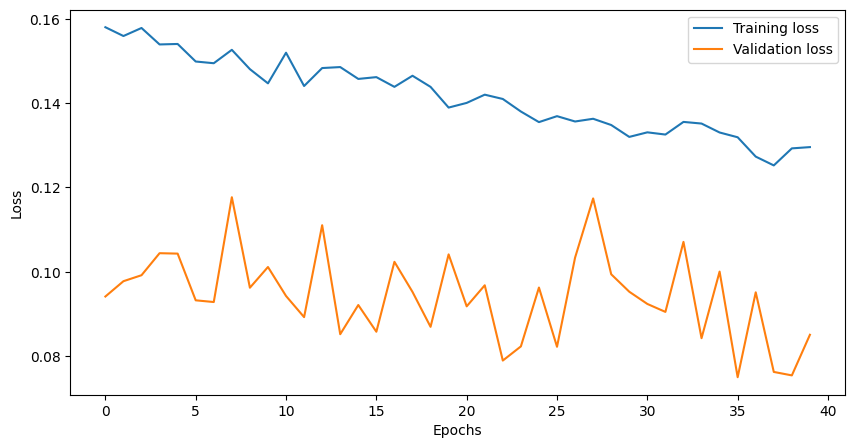

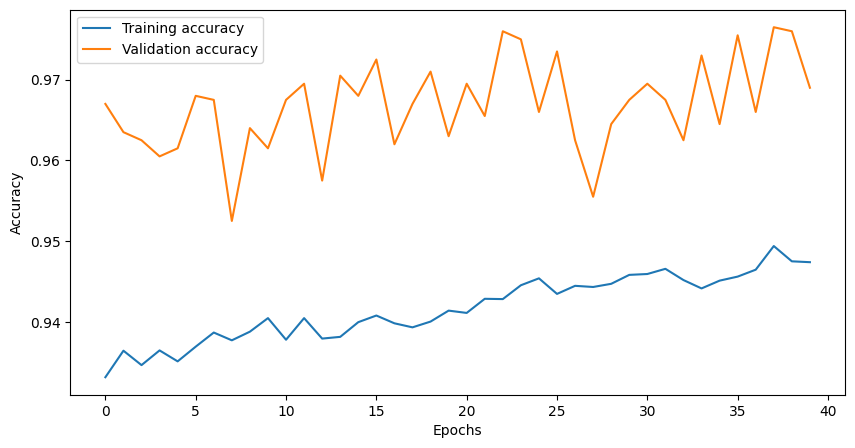

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 5))

axes.plot(history.history["loss"], label="Training loss")
axes.plot(history.history["val_loss"], label="Validation loss")
axes.set_xlabel("Epochs")
axes.set_ylabel("Loss")
axes.legend()
plt.show()


fig, axes2 = plt.subplots(figsize=(10, 5))  # Fixed typo and parameter name
axes2.plot(history.history["accuracy"], label="Training accuracy")
axes2.plot(history.history["val_accuracy"], label="Validation accuracy")
axes2.set_xlabel("Epochs")
axes2.set_ylabel("Accuracy")
axes2.legend()
plt.show()



In [ ]:
import csv
data=[

    [history.history["loss"] ,history.history["val_loss"] ,history.history["accuracy"], history.history["val_accuracy"]]
]

with open("/content/drive/MyDrive/Transformer_classifier_app_1/loss_images/loss_accuracy.csv", mode="a", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(data)


In [ ]:
fig.savefig("/content/drive/MyDrive/Transformer_classifier_app_1/loss_images/loss_v2.png")
fig.savefig("/content/drive/MyDrive/Transformer_classifier_app_1/loss_images/accuracy_v2.png")


The training accuracy is no longer improving beyond 85 percent so we have to remove the droupout layer we added to the encoder part of the transformer and train it

In [ ]:
#calculate precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score
